In [1]:
import os

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df_movies = pd.read_csv(os.path.join('data', 'prepared_movies.csv'))
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            16960 non-null  int64  
 1   cast          16960 non-null  object 
 2   directors     16960 non-null  object 
 3   writers       16960 non-null  object 
 4   keywords      16960 non-null  object 
 5   release_date  16960 non-null  object 
 6   title         16960 non-null  object 
 7   overview      16960 non-null  object 
 8   genres        16960 non-null  object 
 9   popularity    16960 non-null  float64
 10  vote_count    16960 non-null  int64  
 11  vote_average  16960 non-null  float64
 12  poster_path   16891 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 1.7+ MB


1. Select Specific Columns Only

In [3]:
df_demographic = df_movies.copy()
df_demographic = df_demographic[['id', 'title', 'genres', 'release_date', 'vote_count', 'vote_average']]
df_demographic['release_year'] = pd.to_datetime(df_demographic['release_date'], errors='coerce').dt.year
df_demographic.head()

,id,title,genres,release_date,vote_count,vote_average,release_year
0,862,Toy Story,"['Animation', 'Comedy', 'Family']",1995-10-30,5415,7.7,1995
1,8844,Jumanji,"['Adventure', 'Fantasy', 'Family']",1995-12-15,2413,6.9,1995
2,15602,Grumpier Old Men,"['Romance', 'Comedy']",1995-12-22,92,6.5,1995
3,31357,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",1995-12-22,34,6.1,1995
4,11862,Father of the Bride Part II,['Comedy'],1995-02-10,173,5.7,1995


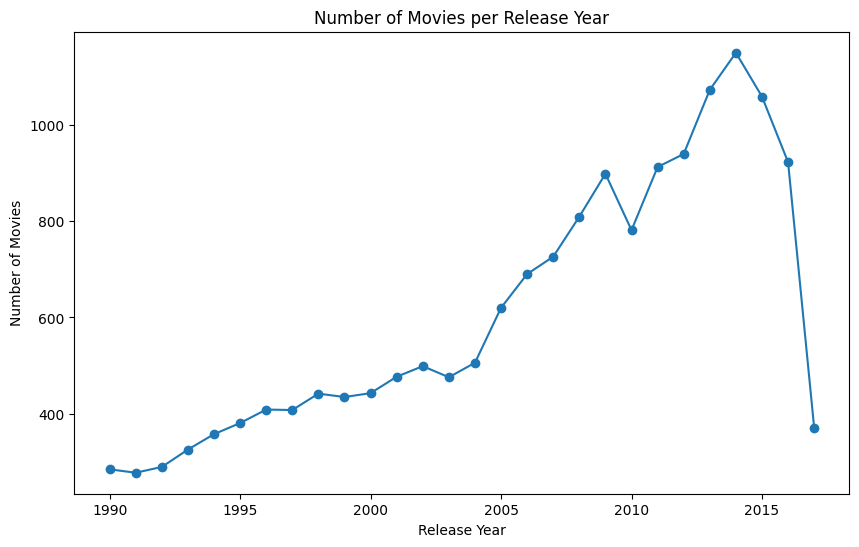

In [4]:
release_year_counts = df_demographic['release_year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
release_year_counts.plot(kind='line', marker='o')
plt.title('Number of Movies per Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()

2. Weighted Rating on All Movies

In [5]:
C = df_demographic['vote_average'].mean() # Vote average across the whole dataset
print(f"Average of vote_average: {C}")

m = df_demographic['vote_count'].quantile(0.9) # Minimum votes required to be listed, 90th percentile
print(f"Minimum votes required: {m}")

Average of vote_average: 5.665436320754718
Minimum votes required: 520.0


In [6]:
print(f"Initial number of movies: {df_demographic.shape[0]}")
df_demographic_filtered = df_demographic[df_demographic['vote_count'] >= m]
print(f"Filtered number of movies after vote count filter: {df_demographic_filtered.shape[0]}")

Initial number of movies: 16960
Filtered number of movies after vote count filter: 1697


In [7]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
# Top 10 movies by weighted rating
df_demographic_filtered['score'] = df_demographic_filtered.apply(weighted_rating, axis=1)
df_demographic_filtered = df_demographic_filtered.sort_values('score', ascending=False).reset_index(drop=True)
df_demographic_filtered[['title', 'release_year', 'vote_count', 'vote_average', 'score']].head(10)

C:\Users\PREDATOR HELIOS 300\AppData\Local\Temp\ipykernel_4556\2620950290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demographic_filtered['score'] = df_demographic_filtered.apply(weighted_rating, axis=1)


,title,release_year,vote_count,vote_average,score
0,The Shawshank Redemption,1994,8358,8.5,8.333975
1,The Dark Knight,2008,12269,8.3,8.192879
2,Fight Club,1999,9678,8.3,8.165663
3,Pulp Fiction,1994,8670,8.3,8.150928
4,Forrest Gump,1994,8147,8.2,8.047932
5,Schindler's List,1993,4436,8.3,8.023573
6,Whiplash,2014,4376,8.3,8.020185
7,Inception,2010,14075,8.1,8.013260
8,Interstellar,2014,11187,8.1,7.991862
9,The Lord of the Rings: The Return of the King,2003,8226,8.1,7.955251


3. Weighted Rating by Genre and Dates

In [9]:
df_demographic['genres'] = df_demographic['genres'].apply(eval)
# Apply the transformation to stack genres
df_demographic_temp = df_demographic.apply(lambda x: pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
df_demographic_temp.name = 'genre'
df_demographic_genres = df_demographic.drop('genres', axis=1).join(df_demographic_temp)
df_demographic_genres.head()

,id,title,release_date,vote_count,vote_average,release_year,genre
0,862,Toy Story,1995-10-30,5415,7.7,1995,Animation
0,862,Toy Story,1995-10-30,5415,7.7,1995,Comedy
0,862,Toy Story,1995-10-30,5415,7.7,1995,Family
1,8844,Jumanji,1995-12-15,2413,6.9,1995,Adventure
1,8844,Jumanji,1995-12-15,2413,6.9,1995,Fantasy


In [10]:
genre_counts = df_demographic_genres['genre'].value_counts()
print(genre_counts)

genre
Drama              7027
Comedy             5217
Thriller           3927
Action             2753
Romance            2442
Horror             2195
Documentary        2144
Crime              1634
Family             1507
Adventure          1488
Science Fiction    1471
Mystery            1046
Fantasy             976
Animation           782
Music               614
TV Movie            517
History             452
War                 303
Foreign             235
Western             171
Name: count, dtype: int64


In [11]:
def filter_and_rank_movies(df, genres=None, release_years=None):
    """
    Filters the DataFrame based on genres and release years, calculates weighted scores, 
    and returns the top 10 movies sorted by score.
    """
    # Filter by genres if specified
    if genres:
        df = df[df['genre'].isin(genres)]
    
    # Filter by release years if specified
    if release_years:
        df = df[df['release_year'].isin(release_years)]
    
    # Remove duplicate rows (e.g., same movie with multiple genres)
    df = df.drop_duplicates(subset=['id', 'title', 'vote_count', 'vote_average', 'release_year'])
    
    # Calculate the average of the 'vote_average' column
    C = df['vote_average'].mean()
    
    # Calculate the quantile of the 'vote_count' column
    m = df['vote_count'].quantile(0.9)
    
    # Filter movies with vote_count >= m
    df_filtered = df[df['vote_count'] >= m]
    
    # Define the weighted rating function
    def weighted_rating(x, m=m, C=C):
        v = x['vote_count']
        R = x['vote_average']
        # Avoid division by zero
        denominator = v + m
        if denominator == 0:
            return C # Return mean if denominator is zero
        return (v / denominator * R) + (m / denominator * C)
    
    # Calculate the score and sort by it
    df_filtered['score'] = df_filtered.apply(weighted_rating, axis=1)
    df_filtered = df_filtered.sort_values('score', ascending=False).reset_index(drop=True)
    
    # Return the top 10 movies
    return df_filtered[['title', 'release_year', 'vote_count', 'vote_average', 'score']].head(10)

In [12]:
filter_and_rank_movies(df_demographic_genres, genres=['Animation'], release_years=None)

C:\Users\PREDATOR HELIOS 300\AppData\Local\Temp\ipykernel_4556\3789811661.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['score'] = df_filtered.apply(weighted_rating, axis=1)


,title,release_year,vote_count,vote_average,score
0,The Lion King,1994,5520,8.0,7.654251
1,Inside Out,2015,6737,7.9,7.623195
2,Up,2009,7048,7.8,7.550021
3,WALL·E,2008,6439,7.8,7.530618
4,Big Hero 6,2014,6289,7.8,7.525368
5,Toy Story,1995,5415,7.7,7.410813
6,Zootopia,2016,4961,7.7,7.390197
7,Finding Nemo,2003,6292,7.6,7.362032
8,Toy Story 3,2010,4710,7.6,7.300491
9,"Monsters, Inc.",2001,6150,7.5,7.276182


4. Sample Recommendations

In [13]:
filter_and_rank_movies(df_demographic_genres, genres=None, release_years=[2000,2001,2002])

C:\Users\PREDATOR HELIOS 300\AppData\Local\Temp\ipykernel_4556\3789811661.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['score'] = df_filtered.apply(weighted_rating, axis=1)


,title,release_year,vote_count,vote_average,score
0,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8.0,7.871583
1,The Lord of the Rings: The Two Towers,2002,7641,8.0,7.851860
2,Memento,2000,4168,8.1,7.830950
3,Gladiator,2000,5566,7.9,7.709526
4,The Pianist,2002,1927,8.1,7.582949
5,Requiem for a Dream,2000,2525,7.9,7.518311
6,Catch Me If You Can,2002,3917,7.7,7.461293
7,Donnie Darko,2001,3574,7.7,7.441216
8,A Beautiful Mind,2001,3087,7.7,7.406122
9,Snatch,2000,2953,7.7,7.394732


5. Saving Genres File

In [14]:
output_path = os.path.join('data', 'final', 'demographic_genres.csv')
df_demographic_genres.to_csv(output_path, index=False)